# Introduction

This notebook demonstrates retreiving information from SQL Databases using Azure OpenAI. The notebook is a part of the larger work on End-to-End virtual assisstant demo.

**Background**

We assume the role of a regional sales manager, who is interesed in learning more about Sales of different Surface products, price points etc. Information on sales is available across multiple tables in the SQL Database. In this notebook, we illustrate how to retrieve information available in SQL databases through natural language questioning. Specifically:

1. We ask (sales related) questions in natural language
2. Pass the question to Azure OpenAI as prompt. The completion we get in return is a SQL query to retrieve the answer
3. We run this SQL query on our database to retrieve an answer
4. Finally, we pass the question and (SQL retreived answer) to Azure OpenAI. The completion we get in return is the answer in natural language.

For information on retreiving information from unstructured data or for the integrated demo, please refer to other material within the bundle.

In [7]:
# Install Packages
import openai
import pyodbc
import pandas as pd
import time
from Utilities.envVars import *
import urllib


First, we set up Azure OpenAI and SQL Server

In [8]:
def run_chat_resouce():
    '''
    Setup Azure OpenAI
    '''
    API_KEY = OpenAiKey
    RESOURCE_ENDPOINT = OpenAiEndPoint
    API_VERSION = OpenAiVersion
    
    return API_KEY, RESOURCE_ENDPOINT, API_VERSION
    
def connect_sql_server(database):
    '''
    Setup SQL Server
    '''
    server = SynapseName
    username = SynapseUser
    password = SynapsePassword
    cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
    cursor = cnxn.cursor()
    
    return cnxn


def run_sql_query(completion):
    '''
    Function to run the generated SQL Query on SQL server and retrieve output.
    Input: AOAI completion (SQL Query)
    Output: Pandas dataframe containing results of the query run
    
    '''
    cnxn = connect_sql_server(SynapsePool)
    df = pd.read_sql(completion, cnxn)
    return df


openai.api_type = "azure"
openai.api_key = run_chat_resouce()[0]
openai.api_base = run_chat_resouce()[1]
openai.api_version = run_chat_resouce()[2]

synapseConnectionString = "Driver={{ODBC Driver 17 for SQL Server}};Server=tcp:{};" \
                "Database={};Uid={};Pwd={};Encrypt=yes;TrustServerCertificate=no;" \
                "Connection Timeout=30;".format(SynapseName, SynapsePool, SynapseUser, SynapsePassword)
params = urllib.parse.quote_plus(synapseConnectionString)
sqlConnectionString = 'mssql+pyodbc:///?odbc_connect={}'.format(params)


# Prompt Engineering

Let us look at the prompts to pass to Azure OpenAI for NL to SQL task. You find this prompt in **generate_nl_to_sql()**.

*System Prompt*

The first step is preparing the system prompt. This sets up the overall tone for GPT to answer Sales question. It also sets informs the bot the kind of questions it is authorized to answer.Following are some characteristics of our system prompt:
1. We first generally describe the bots role (you are a SQL Programmer Assistant)
2. We provide some additional details on the role:

    a. Specify the SQL version to be used
    
    b. Insturctions for what to do if a valid query cannot be produced
    
    c. Instructions on what kind of questions to not answer
    
    d. Any other specific instruction.
    
    
3. Since we are solving an NL to SQL problem, we need to provide the schema of the Sales database next. We provide column names along with datatypes, and relationship information by declaring primary and foreign keys
4. Lastly, we provide some few shot examples. After experimentation on zero shot, few shot examples are added based on the types of queries we see most errors on. We make sure to pass these examples in the "user" and "assistant" role setup. 

*User Prompt*

The next step is to prepare the user prompt. This is just the NL question to be asked. Make sure to follow some basic guidelines while phrasing questions:

1. Be specific in what you are asking
2. Make sure to phrase the question simply. Consider paraphrasing or breaking the question down into smaller segments in the question is involved.


Our next prompt is to convert the query retreived answer into better format. You find this prompt in **generate_sql_to_nl()**

*System Prompt*

Since this is an easier task, the prompt is relatively simpler.

1. Set the overall role for the bot
2. Provide detailed instructions on the task to be performed (convert to natural language. Convert table to html table)
3. provide guidance on what not to do (do not return markdown format)

*User Prompt*

The user prompt for this setup is just passing the original natural language question along with the SQL retreived answer.

In [9]:
from sqlalchemy import create_engine
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
import time
import re

def executeQuery(query, limit=10000):  
    engine = create_engine(sqlConnectionString)
    result = pd.read_sql_query(query, engine)
    result = result.infer_objects()
    for col in result.columns:  
        if 'date' in col.lower():  
            result[col] = pd.to_datetime(result[col], errors="ignore")  

    if limit is not None:  
        result = result.head(limit)  # limit to save memory  
    # session.close()  
    return result

In [10]:
def getTableSchema():
    sqlQuery = """  
    SELECT C.TABLE_NAME, C.COLUMN_NAME, C.DATA_TYPE, T.TABLE_TYPE, T.TABLE_SCHEMA  
    FROM INFORMATION_SCHEMA.COLUMNS C  
    JOIN INFORMATION_SCHEMA.TABLES T ON C.TABLE_NAME = T.TABLE_NAME AND C.TABLE_SCHEMA = T.TABLE_SCHEMA  
    WHERE T.TABLE_TYPE = 'BASE TABLE'  
    """  
    
    # Execute the SQL query and store the results in a DataFrame  
    #df = executeQuery(sqlQuery, limit=None)  
    df = run_sql_query(sqlQuery)
    output=[]
    # Initialize variables to store table and column information  
    curTable = ''  
    columns = []  
    
    # Loop through the query results and output the table and column information  
    for index, row in df.iterrows():
        tableName = f"{row['TABLE_SCHEMA']}.{row['TABLE_NAME']}" 
        colName = row['COLUMN_NAME']  
        dataType = row['DATA_TYPE']   
        if " " in tableName:
            tableName= f"[{tableName}]" 
        colName = row['COLUMN_NAME']  
        if " " in colName:
            colName= f"[{colName}]" 

        # If the table name has changed, output the previous table's information  
        if curTable != tableName and curTable != '':  
            output.append(f"table: {curTable}, columns: {', '.join(columns)}")
            columns = []  
        
        # Add the current column information to the list of columns for the current table  
        columns.append(f"{colName} {dataType}")  
        
        # Update the current table name  
        curTable = tableName  
    
    # Output the last table's information  
    output.append(f"table: {curTable}, columns: {', '.join(columns)}")
    output = "\n ".join(output)
    return output

In [11]:
getTableSchema()

C:\Users\astalati\AppData\Local\Temp\ipykernel_17792\738049794.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(completion, cnxn)


'table: dbo.CustomerCustomerDemo, columns: CustomerID nchar, CustomerTypeID nchar\n table: dbo.CustomerDemographics, columns: CustomerTypeID nchar, CustomerDesc ntext\n table: dbo.Region, columns: RegionID int, RegionDescription nchar\n table: dbo.Territories, columns: TerritoryID nvarchar, TerritoryDescription nchar, RegionID int\n table: dbo.EmployeeTerritories, columns: EmployeeID int, TerritoryID nvarchar\n table: dbo.Employees, columns: EmployeeID int, LastName nvarchar, FirstName nvarchar, Title nvarchar, TitleOfCourtesy nvarchar, BirthDate datetime, HireDate datetime, Address nvarchar, City nvarchar, Region nvarchar, PostalCode nvarchar, Country nvarchar, HomePhone nvarchar, Extension nvarchar, Photo image, Notes ntext, ReportsTo int, PhotoPath nvarchar\n table: dbo.Categories, columns: CategoryID int, CategoryName nvarchar, Description ntext, Picture image\n table: dbo.Customers, columns: CustomerID nchar, CompanyName nvarchar, ContactName nvarchar, ContactTitle nvarchar, Addre

In [12]:
def generate_nl_to_sql(prompt_in, tableSchema, history = []):
    '''
    This GPT4 engine is setup for NLtoSQL tasks on the Sales DB.
    Input: NL question related to sales
    Output: SQL query to run on the sales database
    '''

    sysPrompt = f""" You are a SQL programmer Assistant.Your role is to generate SQL code (SQL Server) to retrieve an answer to a natural language query. Make sure to disambiguate column names when creating queries that use more than one table. If a valid SQL query cannot be generated, only say "ERROR:" followed by why it cannot be generated.
                  Do not answer any questions on inserting or deleting rows from the table. Instead, say "ERROR: I am not authorized to make changes to the data"

                  Use the following sales database schema to write SQL queries:
                  {tableSchema}

                  Examples:
                  User: Which Shipper can ship the product?. SQL Code:
                  Assistant: SELECT s.ShipperID, s.CompanyName FROM Shippers s JOIN Orders o ON s.ShipperID = o.ShipVia JOIN OrderDetails od ON o.OrderID = od.OrderID JOIN Products p ON od.ProductID = p.ProductID;
                  User: Number of units in stock by category and supplier continent? SQL Code:
                  Assistant: SELECT c.CategoryName, s.Country AS SupplierContinent, SUM(p.UnitsInStock) AS TotalUnitsInStock FROM Products p JOIN Categories c ON p.CategoryID = c.CategoryID JOIN Suppliers s ON p.SupplierID = s.SupplierID GROUP BY c.CategoryName, s.Country ORDER BY c.CategoryName, s.Country;
                  User: List Top 10 Products?. SQL Code:
                  Assistant: SELECT TOP 10 Products from Products;
            """
    messages=[
            {"role": "system", "content": sysPrompt}
        ]

    messages.extend(history)
    messages.append({"role": "user", "content": prompt_in})
    
    response = openai.ChatCompletion.create(
        engine="chat16k", # The deployment name you chose when you deployed the ChatGPT or GPT-4 model.
        messages=messages,
        temperature=0,
        max_tokens=2000,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return response['choices'][0]['message']['content']

def generate_sql_to_nl(prompt_in):
    '''
    This GPT4 engine is setup for SQLtoNL tasks on the Sales DB.
    Input: Original question asked. Answer retreived from running SQL query.
    Output: Natural language sentence(s).
    '''
    
    response = openai.ChatCompletion.create(
        engine="chat16k", # The deployment name you chose when you deployed the ChatGPT or GPT-4 model.
        messages=[
            {"role": "system", "content": """You are bot that takes question-answer pairs and converts the answer to natural language. For tabular information return it as an html table. Do not return markdown format."""},
            {"role": "user", "content": prompt_in},
        ],
        temperature=0,
        max_tokens=2000,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    return response['choices'][0]['message']['content']

# Examples

In the subsequent cells, we demonstrate the setup in action. We first try out a simple question. Next, we try out a more involved question, which looks at information from multiple tables. Lastly, we see a multi-turn question i.e a question which requires context from the question previously asked.

**Handling Multi-turn questions in prompts**

In some cases, the user breaks down the question in two multiple parts as the conversation continues. In this case, GPT would require context from the history to be able to comprehend and correctly answer the current question. As a result, we add this extra information to the prompt before sending our current question. Specifically, 
1. We first append our conversation history to the prompt. We keep the "user", "assistant" format we have been following so far with our prompt. Within "user", we add the qustion asked in "user", and the NL answer recieved in "assistant". Make sure to keep the order of Q&A as it occured in the conversation.
2. Finally, we add our current question to the prompt, and pass this newly updated prompt to generate_nl_to_sql()

### Example 1: Products - A simple NLtoSQL query

Our user input is the NL question, as an output, Azure OpenAI generates as completion the SQL query we should run on the Sales database to answer this question

In [13]:
question_products = 'List our all products with their prices.'
tableSchema = getTableSchema()
completion_products = generate_nl_to_sql(question_products,tableSchema)
print(completion_products)

C:\Users\astalati\AppData\Local\Temp\ipykernel_17792\738049794.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(completion, cnxn)


SELECT ProductName, UnitPrice
FROM Products;


We run the SQL query on our database. We retrive the information as a pandas dataframe

In [14]:
sql_output_products = run_sql_query(completion_products)
print(sql_output_products)

C:\Users\astalati\AppData\Local\Temp\ipykernel_17792\738049794.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(completion, cnxn)


                        ProductName  UnitPrice
0                              Chai      18.00
1                             Chang      19.00
2                     Aniseed Syrup      10.00
3      Chef Anton's Cajun Seasoning      22.00
4            Chef Anton's Gumbo Mix      21.35
..                              ...        ...
72                       Röd Kaviar      15.00
73                    Longlife Tofu      10.00
74             Rhönbräu Klosterbier       7.75
75                     Lakkalikööri      18.00
76  Original Frankfurter grüne Soße      13.00

[77 rows x 2 columns]


In [18]:
def generateVisualization(question, data):
    from lida import Manager, TextGenerationConfig , llm
    from lida.datamodel import Goal

    textGen = llm(provider="openai", api_type="azure", api_base=OpenAiEndPoint, api_key=OpenAiKey, api_version=OpenAiVersion) # for azure openai
    textGenConfig = TextGenerationConfig(n=1, temperature=0, model="chat", use_cache=True)

    lida = Manager(textGen)
    summary = lida.summarize(data) # generate data summary
    questionGoal = Goal(index=0, question=question, visualization='', rationale='')
    charts = lida.visualize(summary=summary, goal=questionGoal, textgen_config=textGenConfig)
    return charts[0]

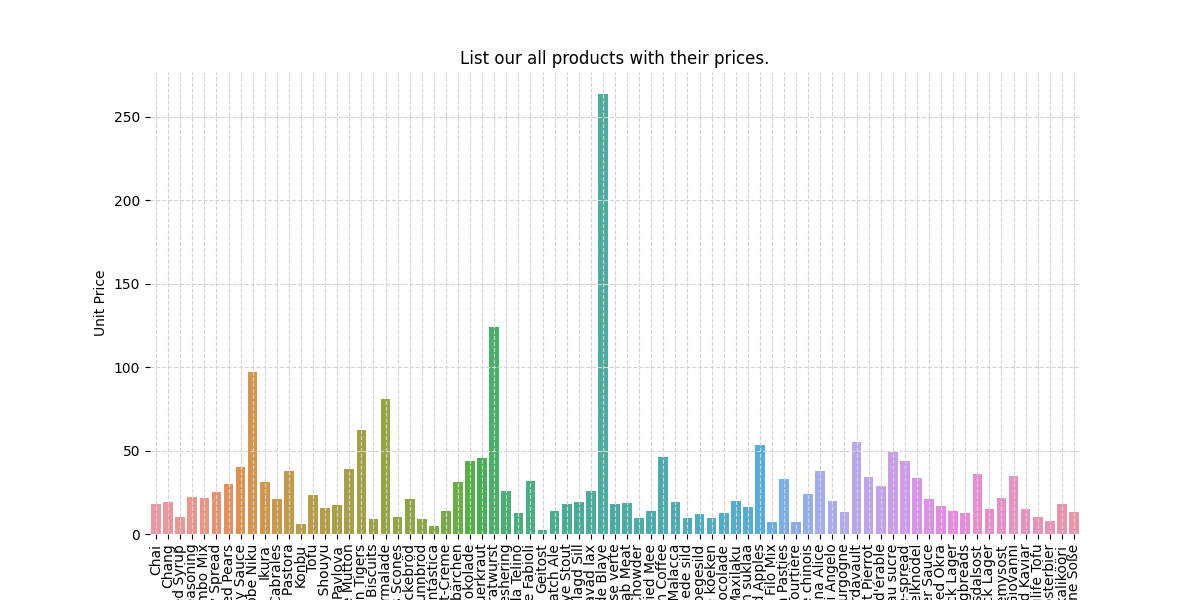

In [19]:
generateVisualization(question_products, sql_output_products)

In [17]:
import base64

imgdata = base64.b64decode(charts[0].raster)
filename = 'some_image.jpg'
with open(filename, 'wb') as f:
    f.write(imgdata)

We ask OpenAI to convert this into a more "Chat-setting friendly" answer. We pass the question, and the answer to Azure OpenAI and ask it to convert the informtaion to an HTML table. In case of a non table asnwer, We ask Azure OpenAI to convert the answer to natural language format.

In [12]:
nl_output = generate_sql_to_nl(str(question_products +  str(sql_output_products.to_dict('list')) ))
#print(nl_output)

### Example 2:  Sales - Example of Joins

In [13]:
question_sales = 'How many customers did placed an order?'
completion_sales = generate_nl_to_sql(question_sales, tableSchema)
print(completion_sales)

SELECT COUNT(DISTINCT CustomerID) AS TotalCustomers FROM Orders;


In [14]:
sql_output_sales = run_sql_query(completion_sales)
print(sql_output_sales)

C:\Users\astalati\AppData\Local\Temp\ipykernel_17024\738049794.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(completion, cnxn)


   TotalCustomers
0              89


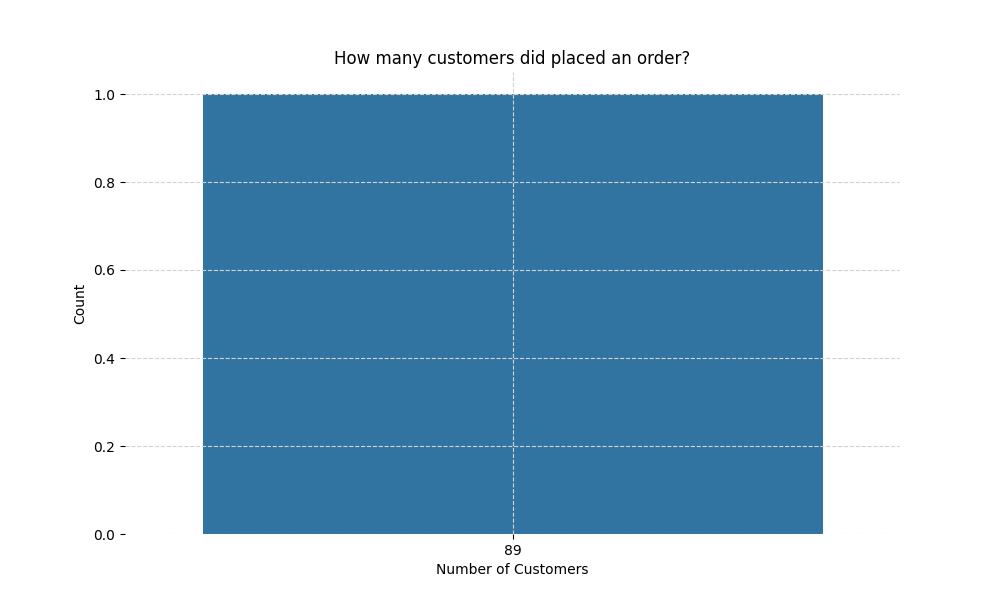

In [15]:
generateVisualization(question_sales, sql_output_sales)

In [16]:
nl_output = generate_sql_to_nl(str(question_sales +  str(sql_output_sales.to_dict('list')) ))
print(nl_output)

There were 89 customers who placed an order.


### Example 3: Stock - Example of Multi Turn questions

In [17]:
question_stock = 'List the total sales grouped by product'
completion_stock = generate_nl_to_sql(question_stock, tableSchema)
print(completion_stock)

SELECT p.ProductName, SUM(od.UnitPrice * od.Quantity) AS TotalSales
FROM Products p
JOIN OrderDetails od ON p.ProductID = od.ProductID
GROUP BY p.ProductName;


In [18]:
sql_output_stock = run_sql_query(completion_stock)
print(sql_output_stock)

C:\Users\astalati\AppData\Local\Temp\ipykernel_17024\738049794.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(completion, cnxn)


                        ProductName  TotalSales
0                      Alice Mutton     35482.2
1                     Aniseed Syrup      3080.0
2                  Boston Crab Meat     19048.3
3                 Camembert Pierrot     50286.0
4                  Carnarvon Tigers     31987.5
..                              ...         ...
72  Uncle Bob's Organic Dried Pears     22464.0
73                 Valkoinen suklaa      3510.0
74                     Vegie-spread     17696.3
75        Wimmers gute Semmelknödel     23009.0
76                    Zaanse koeken      4358.6

[77 rows x 2 columns]


In [20]:
#generateVisualization(question_stock, sql_output_stock)

In [21]:
nl_output = generate_sql_to_nl(str(question_stock +  str(sql_output_stock.to_dict('list')) ))
#print(nl_output)

In [22]:
history = []
history.append({"role": "user","content": question_stock})
history.append({"role": "system","content":nl_output})
history

[{'role': 'user', 'content': 'List the total sales grouped by product'},
 {'role': 'system',
  'content': "<table>\n  <tr>\n    <th>ProductName</th>\n    <th>TotalSales</th>\n  </tr>\n  <tr>\n    <td>Alice Mutton</td>\n    <td>35482.2</td>\n  </tr>\n  <tr>\n    <td>Aniseed Syrup</td>\n    <td>3080.0</td>\n  </tr>\n  <tr>\n    <td>Boston Crab Meat</td>\n    <td>19048.3</td>\n  </tr>\n  <tr>\n    <td>Camembert Pierrot</td>\n    <td>50286.0</td>\n  </tr>\n  <tr>\n    <td>Carnarvon Tigers</td>\n    <td>31987.5</td>\n  </tr>\n  <tr>\n    <td>Chai</td>\n    <td>14277.6</td>\n  </tr>\n  <tr>\n    <td>Chang</td>\n    <td>18559.2</td>\n  </tr>\n  <tr>\n    <td>Chartreuse verte</td>\n    <td>13150.8</td>\n  </tr>\n  <tr>\n    <td>Chef Anton's Cajun Seasoning</td>\n    <td>9424.8</td>\n  </tr>\n  <tr>\n    <td>Chef Anton's Gumbo Mix</td>\n    <td>5801.15</td>\n  </tr>\n  <tr>\n    <td>Chocolade</td>\n    <td>1542.75</td>\n  </tr>\n  <tr>\n    <td>Côte de Blaye</td>\n    <td>149984.2</td>\n  </tr>

In [23]:
question_stock_2 = 'How much of that is for Vegie-spread?'
completion_stock_2 = generate_nl_to_sql(question_stock_2, tableSchema, history)
print(completion_stock_2)

SELECT p.ProductName, SUM(od.Quantity) AS TotalSales
FROM Products p
JOIN OrderDetails od ON p.ProductID = od.ProductID
JOIN Orders o ON od.OrderID = o.OrderID
WHERE p.ProductName = 'Vegie-spread'
GROUP BY p.ProductName;


In [24]:
sql_output_stock_2 = run_sql_query(completion_stock_2)
print(sql_output_stock_2)

C:\Users\astalati\AppData\Local\Temp\ipykernel_17024\738049794.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(completion, cnxn)


    ProductName  TotalSales
0  Vegie-spread         445


In [26]:
nl_output = generate_sql_to_nl(str(question_stock_2 +  str(sql_output_stock_2.to_dict('list'))))
print(nl_output)

The total sales for Vegie-spread is 445.
